In [39]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 30 17:39:10 2018

@author: divya gupta
"""
#get last tweet
import tweepy
import json
import pandas as pd
from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib as mpl
import csv
import matplotlib.pyplot as plt

import operator
from textblob import TextBlob
from textblob import Word
from textblob.sentiments import NaiveBayesAnalyzer
import datetime
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; height = 1000px }</style>"))

def plot_them(company_id,cmp_data,cmp_ht,company_id2,cmp_data2,cmp_ht2):

    # Best and Worst Sentiment Tweet of Self 
    x=cmp_data[cmp_data['Sentiment']==cmp_data['Sentiment'].max()]
    retweet_best=x[x['retweet_count']==x['retweet_count'].max()]['text']
    y=cmp_data[cmp_data['Sentiment']==cmp_data['Sentiment'].min()]
    retweet_worst=y[y['retweet_count']==y['retweet_count'].max()]['text']
    print(company_id + " Tweets")
    print()
    print("Best Tweet: " + retweet_best.item())
    print()
    print("Worst Tweet: " + retweet_worst.item())
    print()
    # Best and Worst Sentiment Tweet of Competition
    x=cmp_data2[cmp_data2['Sentiment']==cmp_data2['Sentiment'].max()]
    retweet_best=x[x['retweet_count']==x['retweet_count'].max()]['text']
    y=cmp_data2[cmp_data2['Sentiment']==cmp_data2['Sentiment'].min()]
    retweet_worst=y[y['retweet_count']==y['retweet_count'].max()]['text']
    print(company_id2 + " Tweets")
    print()
    print("Best Tweet: " + retweet_best.item())
    print()
    print("Worst Tweet: " + retweet_worst.item())
    print()
    
    # Average positive, negative and neutral tweets
    plt.figure(figsize=[15,6])
    comp_counts = cmp_data.groupby(['SentimentClass'])['SentimentClass'].agg(['count'])
    rival_counts = cmp_data2.groupby(['SentimentClass'])['SentimentClass'].agg(['count'])
    comp_counts['pct'] = comp_counts['count']/comp_counts['count'].sum()
    del comp_counts['count']
    rival_counts['pct'] = rival_counts['count']/rival_counts['count'].sum()
    del rival_counts['count']
    fin = pd.DataFrame(list(comp_counts['pct']),index=['Negative', 'Neutral','Positive'] )
    fin[1]=list(rival_counts['pct'])
    fin.columns = [company_id,company_id2]
    fin.plot.bar()
    
    print()
    # User location where maximum tweets are coming from
    x=cmp_data.groupby('user_location')['user_location'].count()
    y=cmp_data2.groupby('user_location')['user_location'].count()
    #x.loc[:, (x != "").any(axis=0)]
    x=x[x==x.max()]
    #print("Most Tweets for "+company_id+" are coming from "+x.index[0])
    #print()
    #y=y[y==y.max()]
    #print("Most Tweets for "+company_id2+" are coming from "+y.index[0])

def comapny_tweets_plots(company_id,cmp_own_data,company_id2,cmp_own_data2):
    # Plotting number of followers
    plt.figure(figsize=[10,15])
    plt.subplot(221)
    x=cmp_own_data['user_followers_count'].max()
    y=cmp_own_data2['user_followers_count'].max()
    plt.bar([company_id,company_id2],[x,y])
    plt.title("Comparison of Number of Followers")
    plt.subplot(222)
    # Plotting average sentiment of the tweets-Now doubtful if it makes sense because a firm will always tweet positive stuff
    x=cmp_own_data['Sentiment'].mean()
    y=cmp_own_data2['Sentiment'].mean()
    plt.bar([company_id,company_id2],[x,y])
    plt.title("Comparison of Average Sentiment of Tweets")
    plt.subplot(223)
    # Plotting retweet count for own firm and competitor
    x=cmp_own_data['retweet_count'].mean()
    y=cmp_own_data2['retweet_count'].mean()
    plt.bar([company_id,company_id2],[x,y])
    plt.title("Comparison of Average Retweets")
    plt.subplot(224)
    # Plotting average number of tweets of own firm and competitor in a certain time frame
    cmp_own_data['created_at'] = pd.to_datetime(cmp_own_data['created_at'], format = '%Y-%m-%d')
    cmp_own_data['created_at'] = pd.DatetimeIndex(cmp_own_data['created_at']).normalize()
    freq_cmp_own_data = cmp_own_data.groupby('created_at')['created_at'].agg(['count'])
    average_value1 = freq_cmp_own_data['count'].mean()
    cmp_own_data2['created_at'] = pd.to_datetime(cmp_own_data2['created_at'], format = '%Y-%m-%d')
    cmp_own_data2['created_at'] = pd.DatetimeIndex(cmp_own_data2['created_at']).normalize()
    freq_cmp_own_data2 = cmp_own_data2.groupby('created_at')['created_at'].agg(['count'])
    average_value2 = freq_cmp_own_data2['count'].mean()

    plt.bar([company_id,company_id2],[average_value1, average_value2])
    plt.title("Comparison of Number of Tweets")
 
def get_them_tweets_all(route,company,company_rival):
    pc = 0
    now = datetime.datetime.now()

    #Authentication

    consumer_key = 'cust_token'
    consumer_secret = 'consumer_secret'
    access_token = 'access_token'
    access_token_secret = 'access_token_secret'

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret) #Interacting with twitter's API
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API (auth, wait_on_rate_limit = True) #creating the API object

    #list1 = ["Walmart", "bostonsci","AbbottNews","LandOLakesInc","Cargill" ]
    list1 = []
    list1.append(company)
    list1.append(company_rival)
    for company_id in list1:
        #Extracting Tweets
        results = []
        if route == 1:
            for tweet in tweepy.Cursor (api.search, q = company_id, lang = "en").items(101): 
                results.append(tweet)
            title1 = " About Company Tweets - "
        elif route == 2:
            for pages in tweepy.Cursor(api.user_timeline, id=company_id, count=101).pages():
                for tweets in pages:        
                    results.append(tweets)
            title1 = " Company Tweets - "
            

        #Store tweets data in a dataframe

        def tweets_df(results):
            id_list = [tweet.id for tweet  in results]
            data_set = pd.DataFrame(id_list, columns = ["id"])

            data_set["text"] = [tweet.text for tweet in results]
            data_set["created_at"] = [tweet.created_at for tweet in results]
            data_set["retweet_count"] = [tweet.retweet_count for tweet in results]
            data_set["user_screen_name"] = [tweet.author.screen_name for tweet in results]
            data_set["user_followers_count"] = [tweet.author.followers_count for tweet in results]
            data_set["user_location"] = [tweet.author.location for tweet in results]
            data_set["Hashtags"] = [tweet.entities.get('hashtags') for tweet in results]

            return data_set
        data_set = tweets_df(results)


        # Remove tweets with duplicate text

        text = data_set["text"]

        for i in range(0,len(text)):
            txt = ' '.join(word for word in text[i] .split() if not word.startswith('https:'))
            data_set.set_value(i, 'text2', txt)

        data_set.drop_duplicates('text2', inplace=True)
        data_set.reset_index(drop = True, inplace=True)
        data_set.drop('text', axis = 1, inplace = True)
        data_set.rename(columns={'text2': 'text'}, inplace=True)

        text = data_set["text"]

        for i in range(0,len(text)):
            textB = TextBlob(text[i])
            sentiment = textB.sentiment.polarity
            data_set.set_value(i, 'Sentiment',sentiment)
            if sentiment <0.00:
                SentimentClass = 'Negative'
                data_set.set_value(i, 'SentimentClass', SentimentClass )
            elif sentiment >0.00:
                SentimentClass = 'Positive'
                data_set.set_value(i, 'SentimentClass', SentimentClass )
            else:
                SentimentClass = 'Neutral'
                data_set.set_value(i, 'SentimentClass', SentimentClass )

        Htag_df = pd.DataFrame()
        j = 0

        for tweet in range(0,len(results)):
            hashtag = results[tweet].entities.get('hashtags')
            #print(hashtag)
            for i in range(0,len(hashtag)):
                Htag = hashtag[i]['text'] 
                Htag_df.set_value(j, 'Hashtag',Htag)
                j = j+1


        # Join all the text from the 1000 tweets
        Hashtag_Combined = " ".join(Htag_df['Hashtag'].values.astype(str))

        ht = " ".join([word for word in Hashtag_Combined.split()
                      if word != 'FUCK'
                      or word != "Fuck"
                      or word != "fuck"])

        text_Combined = " ".join(data_set['text'].values.astype(str))    
        text_final = " ".join([word for word in text_Combined.split()
                                        if word != 'RT'
                                        ])
        #Tweet_mask = imread("twitter_mask.png", flatten=True)

        #Create a Word Cloud
        plt.figure(figsize =[15,15])
        plt.subplot(221)
        plt.title(title1 + company_id + " Hashtags")
        wc = WordCloud(background_color="white", stopwords=STOPWORDS )
        wc.generate(ht)
        plt.imshow(wc)
        plt.axis("off")
        plt.savefig(str(now.day) + company_id + 'Overall_Hashtag_wordCloud.png', dpi=300)
        plt.subplot(222)
        plt.title(title1 +  company_id + " Tweets")
        wc2 = WordCloud(background_color="white", stopwords=STOPWORDS )
        wc2.generate(text_final)
        plt.imshow(wc2)
        plt.axis("off")
        plt.savefig(str(now.day) + company_id + 'Overall_Allwords_wordCloud.png', dpi=300)
        plt.show()
        if pc == 0: 
            cmp_data = data_set
            cmp_ht = hashtag  
                 
        else:
            cmp_rival_data = data_set
            cmp_rival_ht = hashtag
        pc = pc + 1
    return cmp_data,cmp_ht,cmp_rival_data,cmp_rival_ht

def best_and_worst_tweets(data):
    data["best"] = data["Sentiment"].rank(ascending = False, method = "min")
    data["worst"] = data["Sentiment"].rank(method = "min")
    top = data["text"][data["best"] < 2]
    bottom = data["text"][data["worst"] < 2]
    a = top.tolist()
    b = bottom.tolist()
    remove = []
    final = []
    print("Tweets with the Highest Positive Ranking")
    for i in range(len(a)):
        print("{0}. {1}".format(i + 1,a[i]))
        print("")
    print("")
    print("") 
    print("Tweets with the Highest Negative Ranking")
    for i in range(len(b)):
        print("{0}. {1}".format(i + 1,b[i]))
        print("")

def get_them_tweets(company,company_rival):
    cmp_data,cmp_ht,cmp_rival_data,cmp_rival_ht = get_them_tweets_all(1,company,company_rival)
    cmp_data_itself,cmp_ht_itself,cmp_rival_data_itself,cmp_rival_ht_itself = get_them_tweets_all(2,company,company_rival)
    plot_them(company,cmp_data,cmp_ht,company_rival,cmp_rival_data,cmp_rival_ht)
    comapny_tweets_plots(company,cmp_data_itself,company_rival,cmp_rival_data_itself)
    

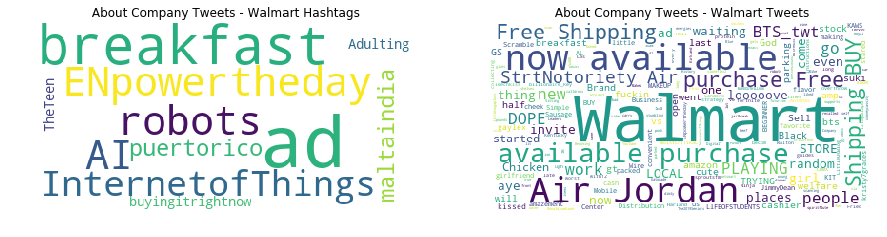

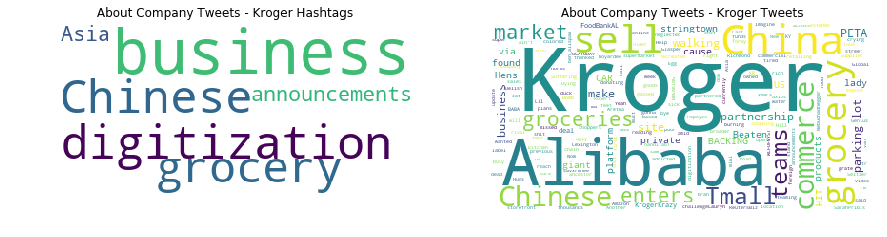

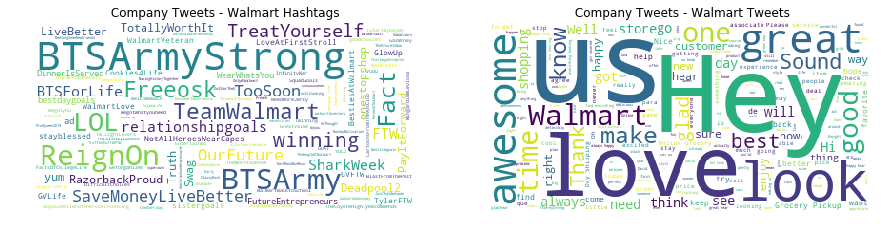

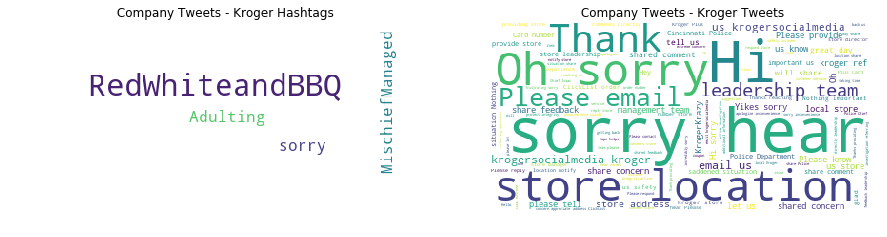

Walmart Tweets

Best Tweet: RT @DeliciouslySavv: Stock Up &amp; Save On @TridentGum 8 Packs Available @Walmart PLUS Enter To Be 1 of 7 Winners To Win Walmart Gift Cards! #…

Worst Tweet: RT @BangBangtan_Esp: [INFO] @BTS_twt Precios para LY: Answer (pre-venta) - Amazon ($21.95) - Walmart ($21.95) ht…

Kroger Tweets

Best Tweet: @SarahPribis You must have been rich. For me it was the Lil Hugs from Kroger.

Worst Tweet: RT @Nebuchadneggar: • Aretha is sick and shut in (or an ancestor, if I missed an update). • Robert Glasper is reading Lauryn Hill in the tr…




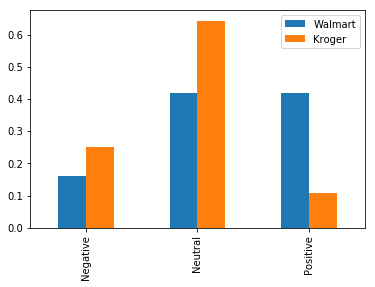

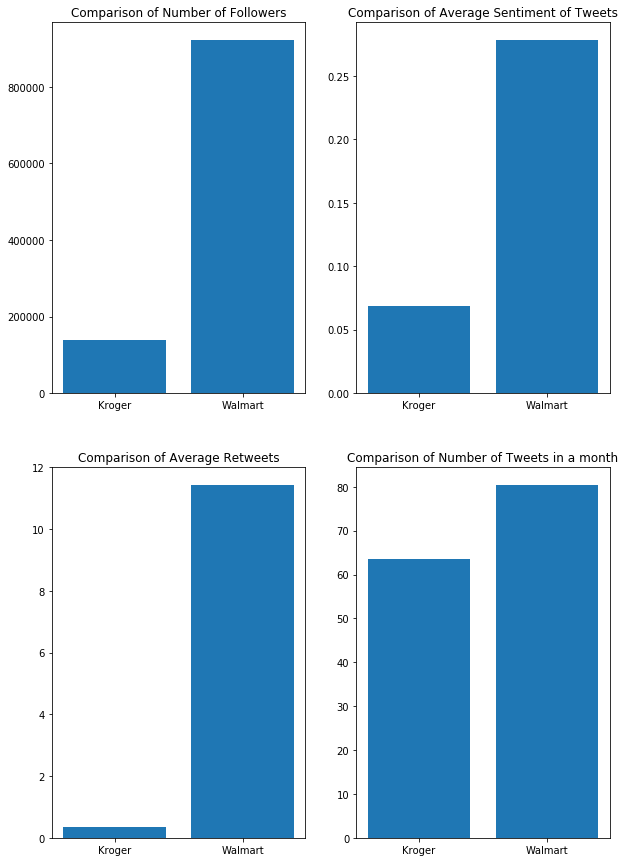

In [40]:
get_them_tweets("Walmart","Kroger")